<a href="https://colab.research.google.com/github/kjji/dlaicourse/blob/master/4_Image_Segmentation_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using UNet

## Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


## Download Dataset

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

--2019-05-02 10:30:18--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  30.2MB/s    in 18s     

2019-05-02 10:30:36 (42.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2019-05-02 10:30:38--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  6.15MB/s    in 3.0s    

2019-05-02 10:30:41 (6.15 MB/s)

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

## Dataset Preparation

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

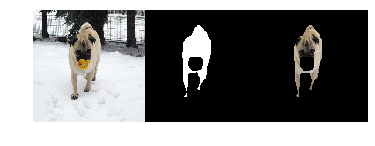

In [0]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [0]:
model = unet()

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

Instructions for updating:
Use tf.cast instead.
i= 1 loss= 0.5574324642686539 val_loss= 0.45944680138067767 mean_iou= 0.12810848899535038 val_mean_iou= 0.3851765502582897


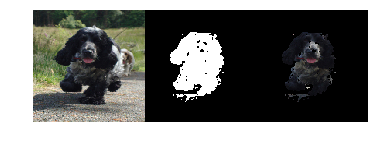

i= 2 loss= 0.4508074311088754 val_loss= 0.45385060527107934 mean_iou= 0.4359874191213416 val_mean_iou= 0.49859306487170135


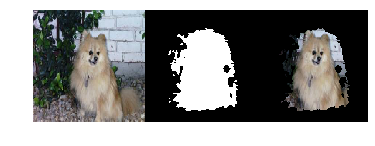

i= 3 loss= 0.4355273076660557 val_loss= 0.41861952434886585 mean_iou= 0.4571611609088776 val_mean_iou= 0.46151585199616174


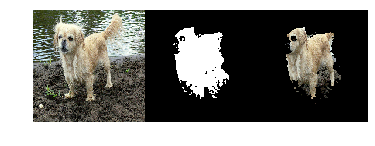

i= 4 loss= 0.41257808415312747 val_loss= 0.38015335527333344 mean_iou= 0.48798167501410394 val_mean_iou= 0.4867567094889554


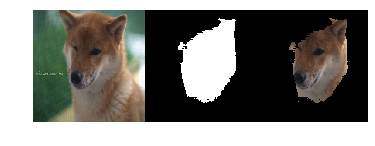

i= 5 loss= 0.37669189825449906 val_loss= 0.32931545647707855 mean_iou= 0.5369588730678166 val_mean_iou= 0.5963546850464561


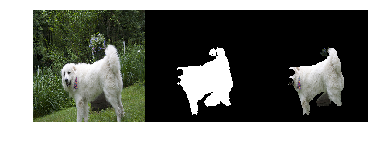

i= 6 loss= 0.33795809861459686 val_loss= 0.30193752863190393 mean_iou= 0.5879083454064583 val_mean_iou= 0.6127275770360773


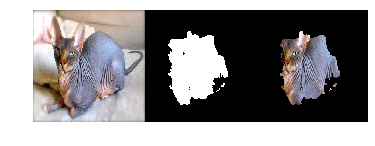

i= 7 loss= 0.3138365629873319 val_loss= 0.306982159614563 mean_iou= 0.624323650990447 val_mean_iou= 0.6563938205892389


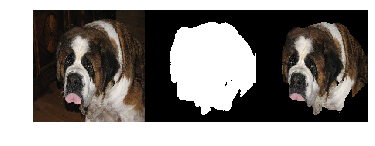

i= 8 loss= 0.28643301939038923 val_loss= 0.2693681242791089 mean_iou= 0.6581671354977507 val_mean_iou= 0.6849474527619102


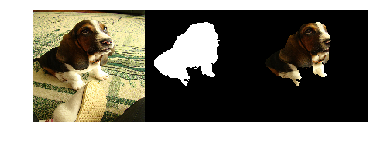

i= 9 loss= 0.2674092246245032 val_loss= 0.2647946368564259 mean_iou= 0.6842176194332507 val_mean_iou= 0.7058633620088751


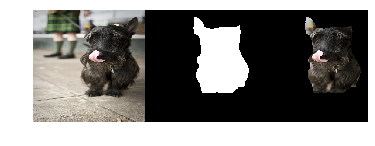

i= 10 loss= 0.25221785685243125 val_loss= 0.25530853596600617 mean_iou= 0.7010654421973991 val_mean_iou= 0.6966516809030012


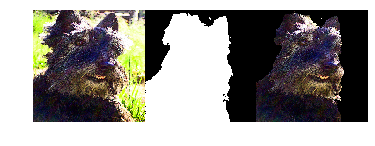

i= 11 loss= 0.2328496999936561 val_loss= 0.2176336022940549 mean_iou= 0.7249949530923747 val_mean_iou= 0.7330314842137423


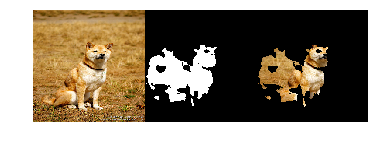

i= 12 loss= 0.2195930086314406 val_loss= 0.221533018079671 mean_iou= 0.7404599799413115 val_mean_iou= 0.733594769781286


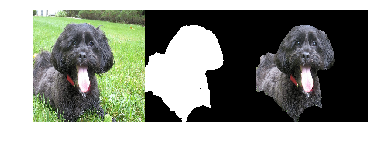

i= 13 loss= 0.20419268303265856 val_loss= 0.2130719775503332 mean_iou= 0.7539667925333868 val_mean_iou= 0.7389888763427734


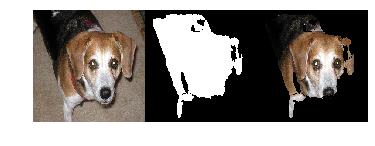

i= 14 loss= 0.19752874038263 val_loss= 0.210432076996023 mean_iou= 0.7638045258173659 val_mean_iou= 0.7479491938244213


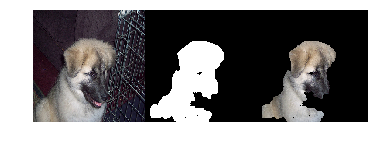

i= 15 loss= 0.18297076824048883 val_loss= 0.24196125702424484 mean_iou= 0.7782625008935797 val_mean_iou= 0.6935214617035605


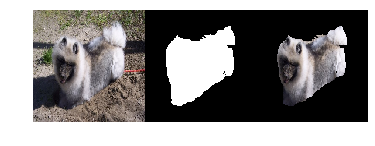

i= 16 loss= 0.1778865514416673 val_loss= 0.221834427931092 mean_iou= 0.7851707448153735 val_mean_iou= 0.7491381493481722


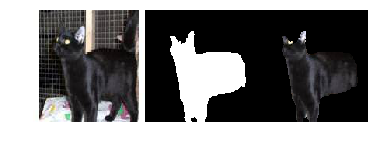

i= 17 loss= 0.16458568494069523 val_loss= 0.21130059388550845 mean_iou= 0.7997185941700522 val_mean_iou= 0.7402980435978282


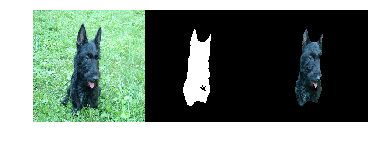

i= 18 loss= 0.15747543638699676 val_loss= 0.23008435829119248 mean_iou= 0.8059231845755556 val_mean_iou= 0.7296412587165833


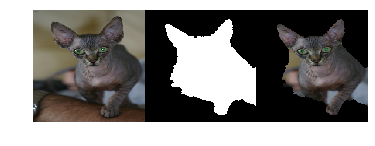

i= 19 loss= 0.15261243535503405 val_loss= 0.19910232722759247 mean_iou= 0.8134739875249123 val_mean_iou= 0.7680773084813898


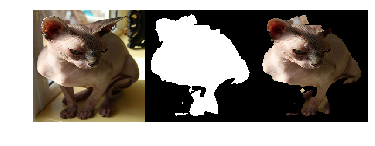

i= 20 loss= 0.14613657468530142 val_loss= 0.2002809833396565 mean_iou= 0.8210508404257091 val_mean_iou= 0.7584544474428351


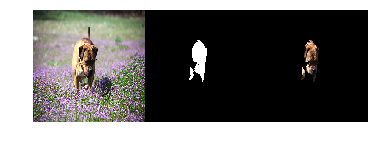

i= 21 loss= 0.13952907742974965 val_loss= 0.20419081910090012 mean_iou= 0.8272886431380494 val_mean_iou= 0.7784393050453879


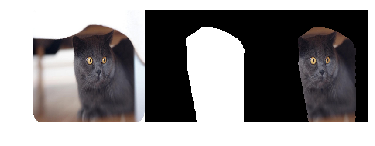

i= 22 loss= 0.13105619464018572 val_loss= 0.20614666559479453 mean_iou= 0.8372202937461469 val_mean_iou= 0.7863630869171836


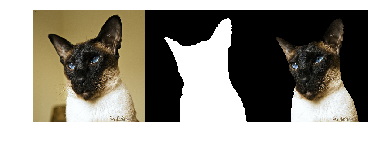

i= 23 loss= 0.1292794252911659 val_loss= 0.20967605303634296 mean_iou= 0.8400707307471532 val_mean_iou= 0.7731579325415872


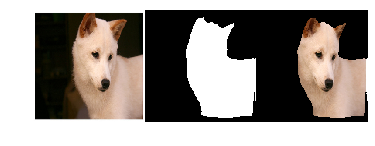

i= 24 loss= 0.12355333896668534 val_loss= 0.21994259547103534 mean_iou= 0.8458030664757507 val_mean_iou= 0.764292673631148


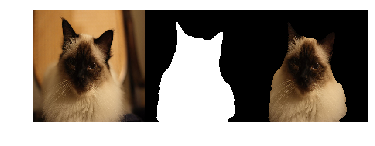

i= 25 loss= 0.11959412244901266 val_loss= 0.22148052806204016 mean_iou= 0.8507115789200073 val_mean_iou= 0.7726794101975181


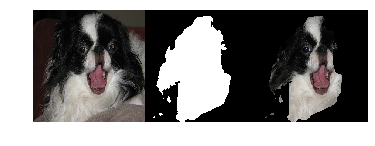

i= 26 loss= 0.1136348494179717 val_loss= 0.2493943924253637 mean_iou= 0.8571289486536696 val_mean_iou= 0.7362238764762878


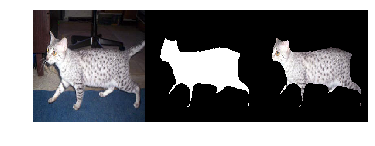

i= 27 loss= 0.1108349269451616 val_loss= 0.23245851695537567 mean_iou= 0.859928943522989 val_mean_iou= 0.7731459899382158


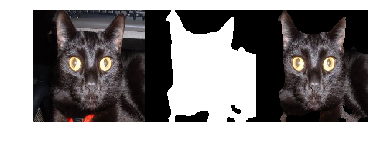

i= 28 loss= 0.10669531999793772 val_loss= 0.23113496737046677 mean_iou= 0.8646820701964913 val_mean_iou= 0.7764757492325522


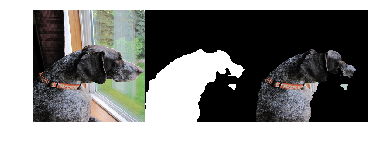

i= 29 loss= 0.10550893043682455 val_loss= 0.22668267244642432 mean_iou= 0.8664489989955676 val_mean_iou= 0.7672697684981606


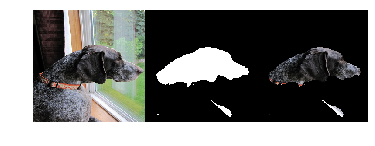

i= 30 loss= 0.10232909571498497 val_loss= 0.22021482343023474 mean_iou= 0.8693531895881375 val_mean_iou= 0.7681661194021051


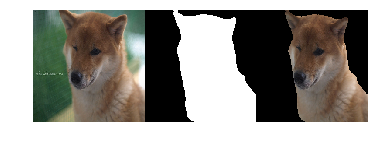

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

## Prediction with new sample

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2019-05-02 11:30:43--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 143.204.101.49, 143.204.101.113, 143.204.101.55, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|143.204.101.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test.jpg’

test.jpg                [ <=>                ]  61.74K  --.-KB/s    in 0.01s   

2019-05-02 11:30:43 (5.21 MB/s) - ‘test.jpg’ saved [63219]



## Prediction

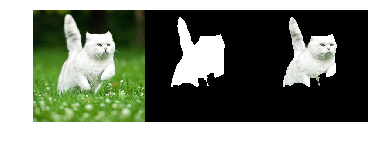

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()